# visualizing the images

In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets_v2.mri_dataset_inram import MRISegmentation3DDataset
from twaidata.torchdatasets_v2.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading MSS3 flair t1 mask dataset

In [3]:
from twaidata.torchdatasets_v2.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser

In [4]:
parser = MSS3MultiRaterDataParser(
        # paths on the cluster for the in house data
        "/home/s2208943/datasets/Inter_observer",
        "/home/s2208943/preprocessed_data/MSS3_InterRaterData"
    )

mss3_ds = ArrayMRISegmentationDatasetFromFile(parser) 

In [5]:
IDs = [v[2] for v in mss3_ds]

### Loading MSS3 predictions

In [6]:
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True, ncols=100):
        # print(fID)
        # break
        if ".npz" in fID and "model_WMH_samples" not in fID:
            ID = fID.split("_out_maps")[0]
            output_maps_data = np.load(os.path.join(output_maps_dir,fID))
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                if key == "seg":
                    continue
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [7]:
# model_name = "SSN_Ens_Mean"
output_maps = {}
for model_name in ["nnunet/nnunetX2SsnEns2D", "nnunet/nnunet2D"]:
    output_maps_dir = f"/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/MSS3_InterRaterData/output_maps/{model_name}/"
    out_maps, key_order = load_output_maps(output_maps_dir)
    output_maps[model_name] = out_maps

100%|███████████████████████████████████████████████████████████████| 68/68 [00:14<00:00,  4.53it/s]


### Loading the Fazekas Categories

In [8]:
from trustworthai.journal_run.new_MIA_fazekas_and_QC.dataset_setup import *

In [9]:
cvd_data, adni_data, challenge_data, mss3_data = load_spreadsheets(include_MSS3=True)


challenge shapes before and after cleanup
(175, 1532)
(175, 1465)
cvd shapes before and after cleanup
(250, 1552)
(250, 1402)
adni shapes before and after cleanup
(299, 1544)
(299, 1374)
mss3 shapes before and after cleanup
(68, 46)
(68, 44)


In [10]:
IDs_map = {ID:"_".join(ID.split("_")[1:4]) for ID in IDs}
reverse_IDs_map = {value:key for key, value in IDs_map.items()}

In [11]:
mss3_data['ssn_ens']

ID  WMH_PV  WMH_Deep  Total      dice        f1        avd   
0    MSS3_ED_001_V1     2.0       1.0    3.0  0.704165  0.386266  22.023810  \
1    MSS3_ED_002_V1     3.0       3.0    6.0  0.537512  0.328947  61.581569   
2    MSS3_ED_003_V1     2.0       2.0    4.0  0.528705  0.441983  61.660237   
3    MSS3_ED_004_V1     3.0       2.0    5.0  0.472049  0.297359  68.100723   
4    MSS3_ED_005_V1     1.0       1.0    2.0  0.234711  0.137246  83.359980   
..              ...     ...       ...    ...       ...       ...        ...   
63   MSS3_ED_017_V0     NaN       NaN    NaN  0.287648  0.353086  57.864358   
64   MSS3_ED_050_V0     NaN       NaN    NaN  0.763039  0.472959  37.415579   
65  MSS3_ED_050_V2b     NaN       NaN    NaN  0.627215  0.439093  52.440571   
66   MSS3_ED_050_V3     NaN       NaN    NaN  0.638214  0.316424  52.162269   
67   MSS3_ED_102_V0     NaN       NaN    NaN  0.367630  0.538226  71.661721   

      recall  deep_sample_div_std  deep_sample_div_IQR  ...   
0   0.294118           560.570557               358.50  ...  \
1   0.200000          1396.016846              1430.00  ...   
2   0.306452           282.660065               267.50  ...   
3   0.175926           170.669144               181.75  ...   
4   0.075410           804.294434               861.75  ...   
..       ...                  ...                  ...  ...   
63  0.230088           125.153061               116.25  ...   
64  0.320513          1717.650513              1651.75  ...   
65  0.296970           866.251099               972.75  ...   
66  0.190217           645.014221               754.50  ...   
67  0.385965           518.874207               270.75  ...   

    all_sample_div_skew  all_sample_div_vd_std  all_sample_div_vd_IQR   
0              1.142419              75.044083              69.725884  \
1              0.334688              48.475227              56.559517   
2              0.219098              48.056366              62.083624   
3              0.312798              35.019558              43.212389   
4              0.853284              98.984100             111.104955   
..                  ...                    ...                    ...   
63             0.446312              50.620552              61.130136   
64             0.313657              25.046648              26.580737   
65             0.223477              34.942036              41.340386   
66             0.114523              26.482073              31.018442   
67             1.726968              98.790794              73.200264   

    all_sample_div_vd_skew  all_min_sample  all_max_sample  all_25th_p_sample   
0                 1.142419           703.0          4420.0            1342.25  \
1                 0.334688          2409.0         11334.0            4641.00   
2                 0.219098          1253.0          5680.0            2356.25   
3                 0.312797          1599.0          4888.0            2374.00   
4                 0.853284           551.0          4920.0            1230.00   
..                     ...             ...             ...                ...   
63                0.446312           443.0          1877.0             750.75   
64                0.313657          8067.0         18731.0           11184.75   
65                0.223478          3456.0         10382.0            5292.00   
66                0.114522          3675.0          9092.0            5261.75   
67                1.726968           417.0          3002.0             659.50   

    all_75th_p_sample  all_25th_p_vd  all_75th_p_vd  
0             2347.00      -6.852880      62.873005  
1             7781.75     -16.423555      40.135962  
2             4145.50     -18.242540      43.841084  
3             3594.75     -15.964601      27.247787  
4             2733.25      -9.090909     102.014046  
..                ...            ...            ...  
63            1286.25     -14.297945      46.832191  
64           14510.00     -10

In [12]:
mask_vols = []
wmh_vols = []
fazekas_pv = []
fazekas_deep = []
for sid in mss3_data['ssn_ens']['ID']:
    iid = sid
    scan_id = np.where(np.array(IDs) == iid)[0].item()
    data = mss3_ds[scan_id]
    mask = data[0][2]
    wmh = data[1][-1]
    
    wmh_vol = wmh.sum().item()
    mask_vol = mask.sum().item()
    
    mask_vols.append(mask_vol)
    wmh_vols.append(wmh_vol)
    fazekas_pv.append(mss3_data['ssn_ens'][mss3_data['ssn_ens']['ID'] == sid]['WMH_PV'].values[0])
    fazekas_deep.append(mss3_data['ssn_ens'][mss3_data['ssn_ens']['ID'] == sid]['WMH_Deep'].values[0])
    

In [13]:
mask.shape

torch.Size([53, 240, 240])

In [14]:
stats_df = {
    "wmh_vol":wmh_vols,
    "mask_vol":mask_vols,
    "faz_pv":fazekas_pv,
    "faz_deep":fazekas_deep,
    "wmh_to_brain_size": np.array(wmh_vols) / np.array(mask_vols)
}

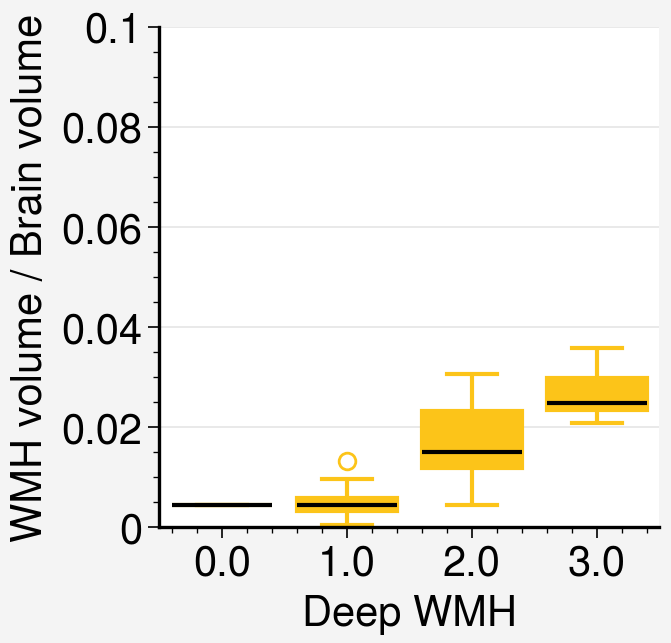

In [15]:
colour = "yellow5"
fig, ax = pplt.subplots(ncols=1, nrows=1, fontsize=15)
boxplot = sns.boxplot(stats_df, x='faz_deep', y='wmh_to_brain_size', ax=ax, color=colour, linewidth=1.5, linecolor=colour)

for i, box in enumerate(boxplot.artists):
    boxplot.lines[4 + (i * 6)].set_color('black')
# make the face colour consistent
for patch in boxplot.artists:
    patch.set_facecolor(colour)

plt.ylim(0, 0.1)
ax.set_xticks(range(0, 4))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1.2)  # Thicker bottom spine
ax.spines['left'].set_linewidth(1.2)  # Thicker left spine
ax.format(xlabel="Deep WMH", ylabel="WMH volume / Brain volume")
fig.save("images/mss3_deep_vol_dist.pdf")


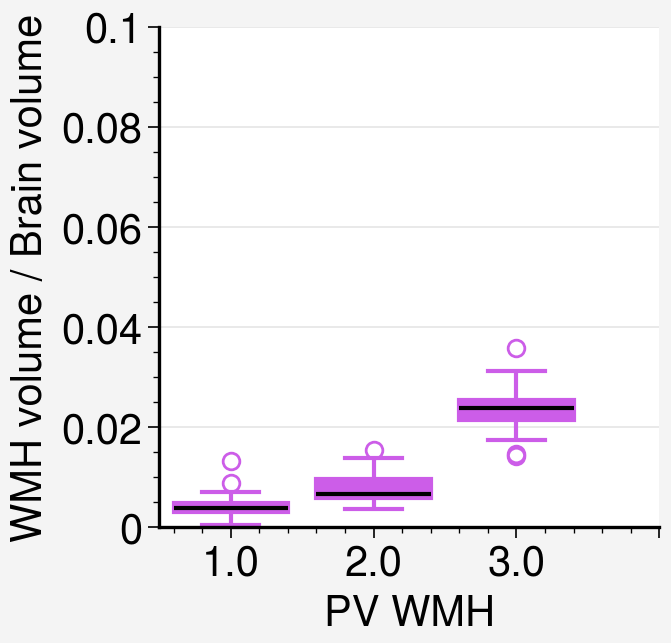

In [16]:
colour = "grape5"
fig, ax = pplt.subplots(ncols=1, nrows=1, fontsize=15)
boxplot = sns.boxplot(stats_df, x='faz_pv', y='wmh_to_brain_size', ax=ax, color=colour, linewidth=1.5, linecolor=colour)

for i, box in enumerate(boxplot.artists):
    boxplot.lines[4 + (i * 6)].set_color('black')
# make the face colour consistent
for patch in boxplot.artists:
    patch.set_facecolor(colour)

plt.ylim(0, 0.1)
ax.set_xticks(range(0, 4))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_linewidth(1.2)  # Thicker bottom spine
ax.spines['left'].set_linewidth(1.2)  # Thicker left spine
ax.format(xlabel="PV WMH", ylabel="WMH volume / Brain volume")

fig.save("images/mss3_pv_vol_dist.pdf")

In [16]:
import proplot as pplt
import SimpleITK as sitk

In [17]:
def plot_brain_image(ds, IDs, output_maps_ssnens, output_maps_deterministic, target_pID, df, reverse_IDs_map):
    IDs = np.array(IDs)
    scan_id = np.where(IDs == reverse_IDs_map[target_pID])[0].item()
    
    nslices = ds[scan_id][0][0].shape[0]
    gap = nslices // 6

    fig = pplt.figure(space=0, refwidth='20em')
    axs = fig.subplots(nrows=4, ncols=6)
    # axs.format(grid=False, xlocator='null', ylocator='null')
    # for ax in axs:
    #     for spine in ax.spines:
    #         ax.spines[spine].set_color('none')
            
    # print(ds[scan_id][0][0].shape)
    
    # imgpath = f'/disk/scratch/s2208943/MOUNTS/BRICIA/E181935_MSS_III_Res/MRI/STRUCTURAL_ALL_VISITS/MSS3_{key[0:6]}/ses_V{key.split("V")[1]}/segmentations/Strokes/MSS3_{key}_strokes_binary.nii.gz'
    imgpath = f'/disk/scratch/s2208943/MOUNTS/BRICIA/E181935_MSS_III_Res/MRI/STRUCTURAL_ALL_VISITS/MSS3_{key[0:6]}/ses_V{key.split("V")[1]}/overlays/MSS3_{key}_WMH_and_strokes.nii.gz'
    img = sitk.ReadImage(imgpath)

#     original_spacing = img.GetSpacing()
#     original_size = img.GetSize()
#     out_spacing = (1,1,3)

#     out_size = [
#         int(np.round(orig_size * orig_spacing / out_spacing))
#         for (orig_size, orig_spacing, out_spacing) 
#         in zip(original_size, original_spacing, out_spacing)
#     ]
#     resample = sitk.ResampleImageFilter()
#     resample.SetOutputSpacing(original_spacing)
#     resample.SetSize(out_size)
#     resample.SetOutputDirection(img.GetDirection())      # sets the output direction cosine matrix...
#     resample.SetOutputOrigin(img.GetOrigin())
#     resample.SetTransform(sitk.Transform())
#     resample.SetDefaultPixelValue(0)#itk_image.GetPixelIDValue())
#     resample.SetInterpolator(sitk.sitkNearestNeighbor)
#     img = resample.Execute(img)
    arr = sitk.GetArrayFromImage(img)
    
    # print(np.unique(arr))
    # if len(np.unique(arr)) == 1:
    #     return

    for i in range(4):
        row = i * 6
        islice = gap * (i + 1) + 4

        # flair
        axs[row].imshow(ds[scan_id][0][0][islice], cmap='gray', vmin=-3, vmax=3, origin='lower')

        # flair + umap
        axs[row +1].imshow(ds[scan_id][0][0][islice], cmap='gray', vmin=-3, vmax=3, origin='lower')
        axs[row +1].imshow(output_maps_ssnens[IDs[scan_id]][0][islice], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

        # flair + seg
        axs[row +2].imshow(ds[scan_id][0][0][islice], cmap='gray', vmin=-3, vmax=3, origin='lower')
        axs[row +2].imshow(output_maps_ssnens[IDs[scan_id]][1][islice] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')  
        
        # flair + umap
        axs[row +3].imshow(ds[scan_id][0][0][islice], cmap='gray', vmin=-3, vmax=3, origin='lower')
        axs[row +3].imshow(output_maps_deterministic[IDs[scan_id]][0][islice], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

        # flair + seg
        axs[row +4].imshow(ds[scan_id][0][0][islice], cmap='gray', vmin=-3, vmax=3, origin='lower')
        axs[row +4].imshow(output_maps_deterministic[IDs[scan_id]][1][islice] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')  
        
        # flair + stroke
        axs[row +5].imshow(arr[int(islice * arr.shape[0]/ds[scan_id][0][0].shape[0])], cmap='gray', origin='lower', vmin=0, vmax=18000) 

    # fig.savefig("figname.png", bbox_inches='tight', dpi=300)

In [18]:
# for key in list(reverse_IDs_map.keys())[::-1]:
# for key in ['ED_020_V1']:
# for key in 'ED_102_V4 ED_102_V0 ED_077_V1 ED_050_V0 ED_041_V1 ED_038_V1 ED_027_V1 ED_029_V1 ED_024_V1 ED_020_V1 ED_019_V1 ED_013_V1 ED_012_V1 ED_009_V1 ED_005_V1'.split(' '):
#     print(key)
#     plot_brain_image(mss3_ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], key, mss3_data['ssn_ens'], reverse_IDs_map)
#     plt.show()

In [30]:
def plot_brain_image_singlesice(ds, IDs, output_maps_ssnens, output_maps_deterministic, target_pID, df, reverse_IDs_map, islice_index, r1=20, r2=10, figtitles=False, circle_centre=None, circle_radius=None, second_circle_centre=None, second_circle_radius=None, mark_locs=None):
    IDs = np.array(IDs)
    scan_id = np.where(IDs == reverse_IDs_map[target_pID])[0].item()
    
    nslices = ds[scan_id][0][0].shape[0]
    gap = nslices // 6
    islice = gap * (islice_index + 1) + 4

    fig = pplt.figure(space=0, refwidth='20em')
    axs = fig.subplots(nrows=1, ncols=5)
    axs.format(grid=False, xlocator='null', ylocator='null')
    for ax in axs:
        for spine in ax.spines:
            ax.spines[spine].set_color('none')

            
    flair = ds[scan_id][0][0]
    flair = flair.clone()
    mask = ds[scan_id][0][2]
    flair[mask==0] = flair.min()
            
    # flair
    axs[0].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    if circle_centre is not None:
        circle = plt.Circle((circle_centre[0]-r2, circle_centre[1]-r1), radius=circle_radius, color='black', fill=False, linewidth=3.5)
        axs[0].add_patch(circle)
        circle = plt.Circle((circle_centre[0]-r2, circle_centre[1]-r1), radius=circle_radius, color='white', fill=False, linewidth=1.7)
        axs[0].add_patch(circle)
        circle = plt.Circle((circle_centre[0]-r2, circle_centre[1]-r1), radius=circle_radius, color='r', fill=False, linewidth=1.7, linestyle='--')
        axs[0].add_patch(circle)
        
    if second_circle_centre is not None:
        circle = plt.Circle((second_circle_centre[0]-r2, second_circle_centre[1]-r1), radius=second_circle_radius, color='black', fill=False, linewidth=3.5)
        axs[0].add_patch(circle)
        circle = plt.Circle((second_circle_centre[0]-r2, second_circle_centre[1]-r1), radius=second_circle_radius, color='white', fill=False, linewidth=1.7)
        axs[0].add_patch(circle)
        circle = plt.Circle((second_circle_centre[0]-r2, second_circle_centre[1]-r1), radius=second_circle_radius, color='r', fill=False, linewidth=1.7, linestyle='--')
        axs[0].add_patch(circle)
        
    if mark_locs is not None:
        for mark in mark_locs:
            axs[0].scatter(mark[0], mark[1], marker=mark[2], s=100, c='white')
            # axs[0].scatter(mark[0], mark[1], marker=mark[2], s=50, c='grape7')

    # flair + umap ssn ens
    axs[1].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[1].imshow(output_maps_ssnens[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    # flair + ssn ens
    axs[2].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[2].imshow(output_maps_ssnens[IDs[scan_id]][1][islice][r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')  
    
    # flair + umap deterministic
    axs[3].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[3].imshow(output_maps_deterministic[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    # flair + ssn ens
    axs[4].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[4].imshow(output_maps_deterministic[IDs[scan_id]][1][islice][r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')
    
    if figtitles:
        # axs[0].set_title("FLAIR", fontweight='bold')
        axs[1].set_title("SSN-Ens (nnUNet)\nUQ map", fontweight='bold')
        axs[2].set_title("SSN-Ens (nnUNet)\nWMH seg.", fontweight='bold')
        axs[3].set_title("SEnt (nnUNet)\nUQ map", fontweight='bold')
        axs[4].set_title("SEnt (nnUNet)\nWMH seg.", fontweight='bold')
        axs.format(titleloc='uc', titleborder=False, fontsize=13)

    plt.savefig(f"images/nnunet (report 2) mss3_{target_pID}_{islice_index}.png", dpi=200)
    plt.show()

In [21]:
output_maps.keys()

dict_keys(['nnunet/nnunetX2SsnEns2D', 'nnunet/nnunet2D'])

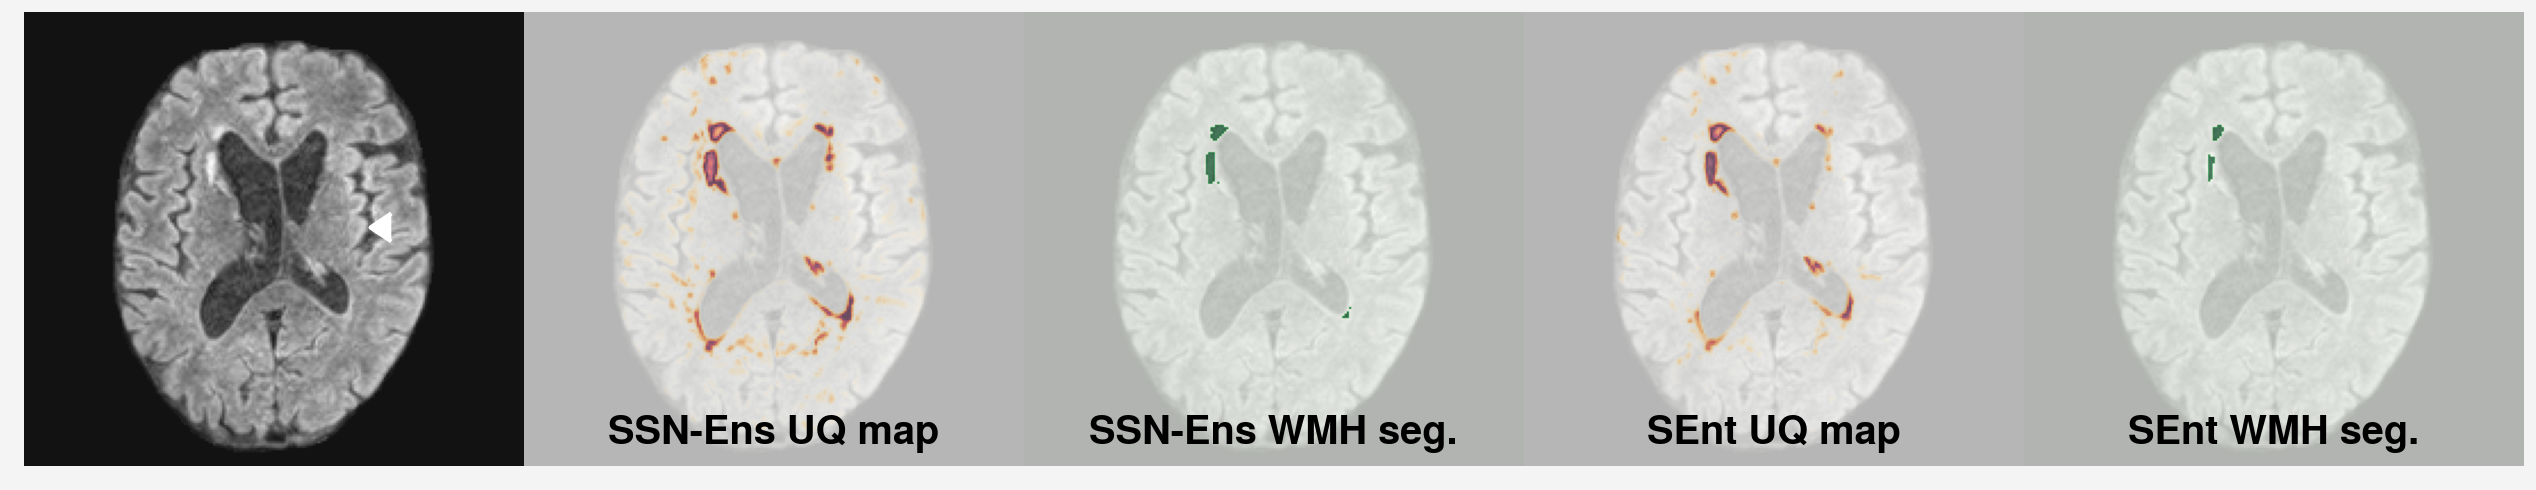

In [22]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_005_V1',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=2, r1=20, r2=10, figtitles=True, mark_locs=[[152, 105, 4]])

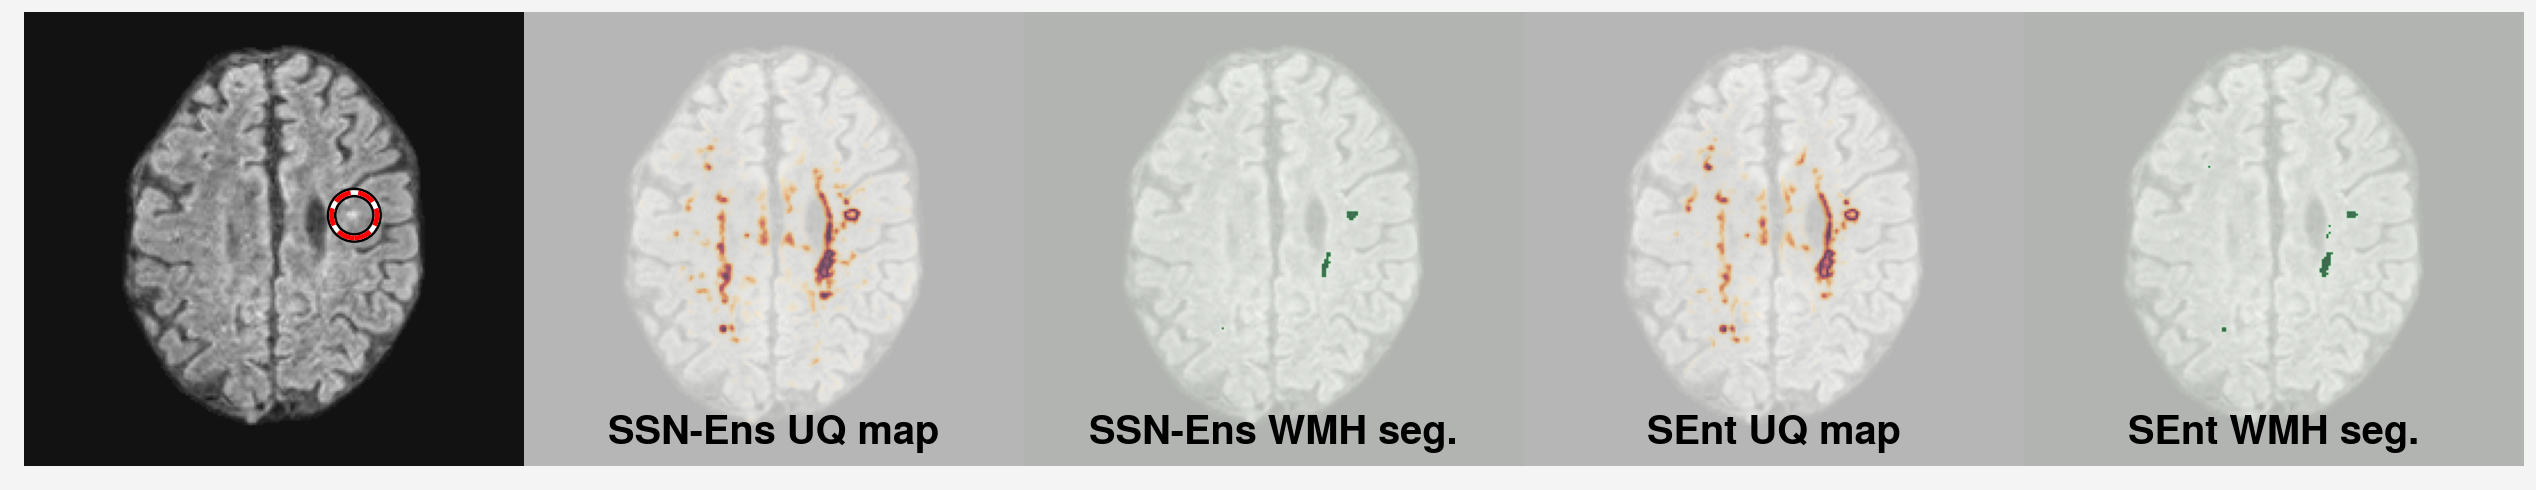

In [23]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_005_V1', 
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=3, r1=20, r2=10, figtitles=True, circle_centre=(155, 130), circle_radius=10)

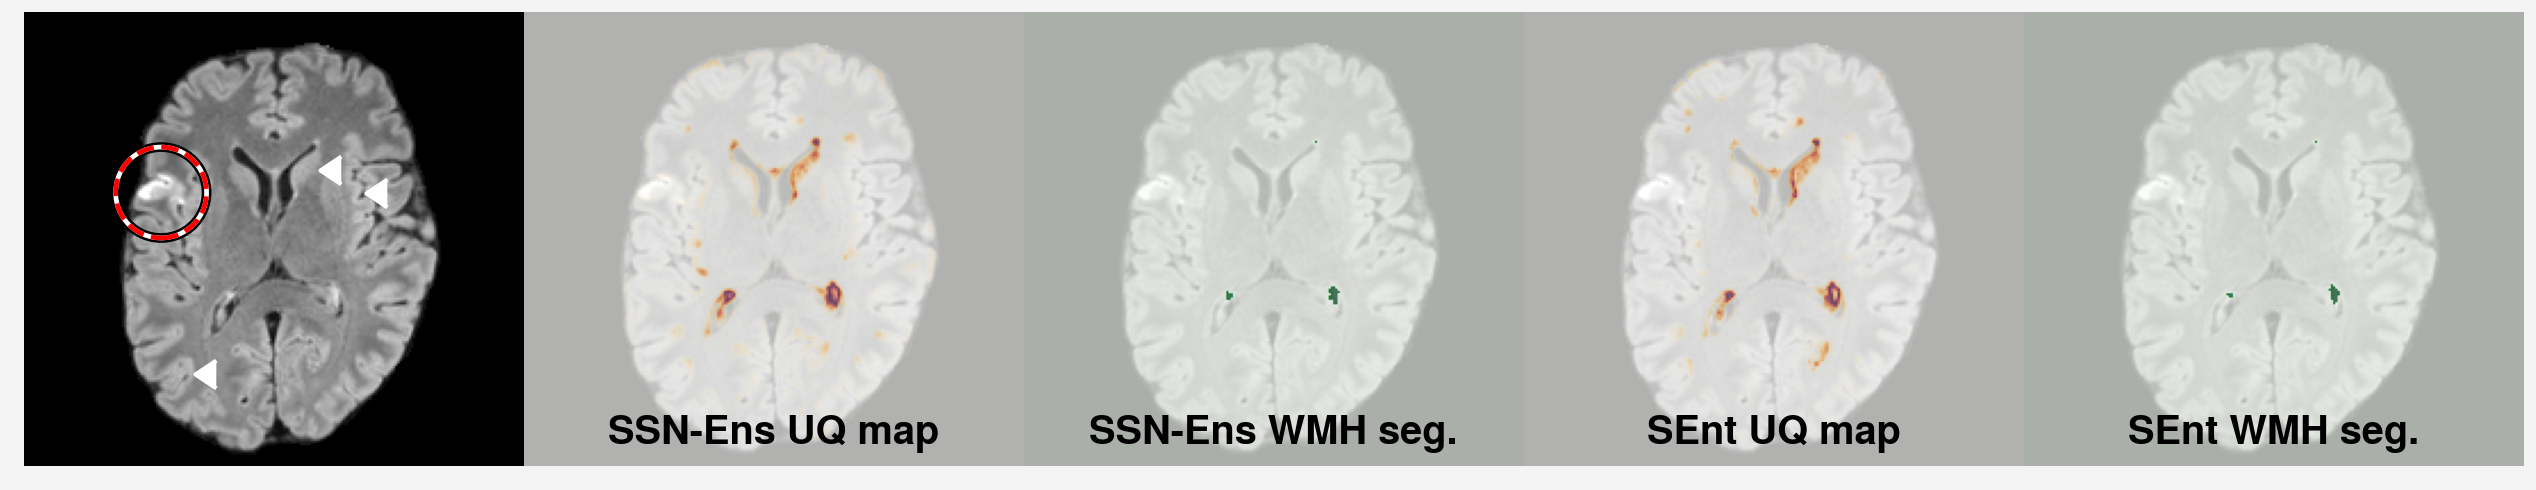

In [24]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_009_V1',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=2, r1=20, r2=10, figtitles=True, circle_centre=(70, 140), circle_radius=20, mark_locs=[[150, 120, 4], [130, 130, 4], [75, 40, 4]])

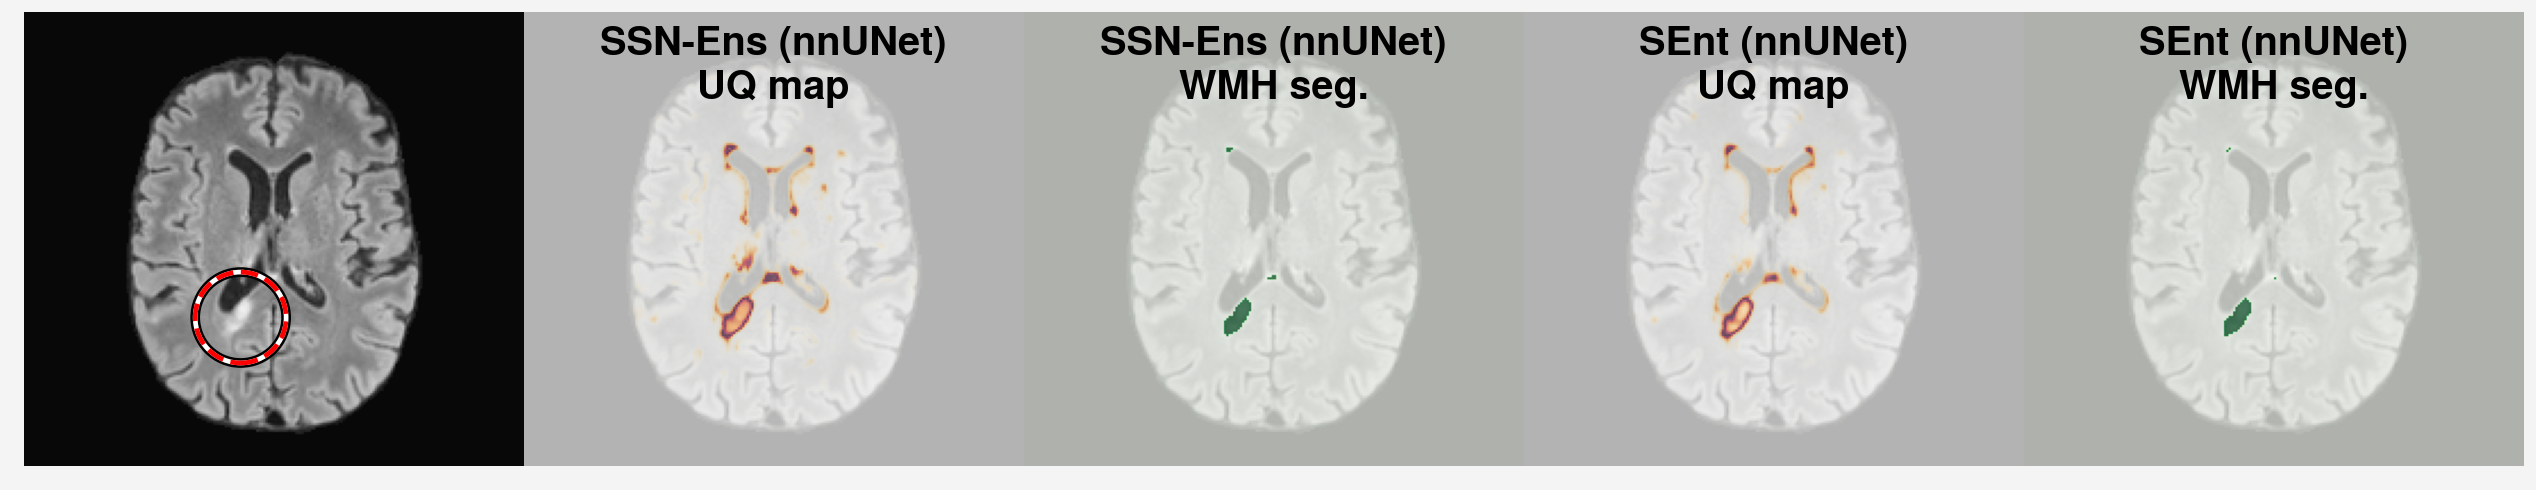

In [31]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_012_V1',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=2, r1=20, r2=10, figtitles=True, circle_centre=(105, 85), circle_radius=20)

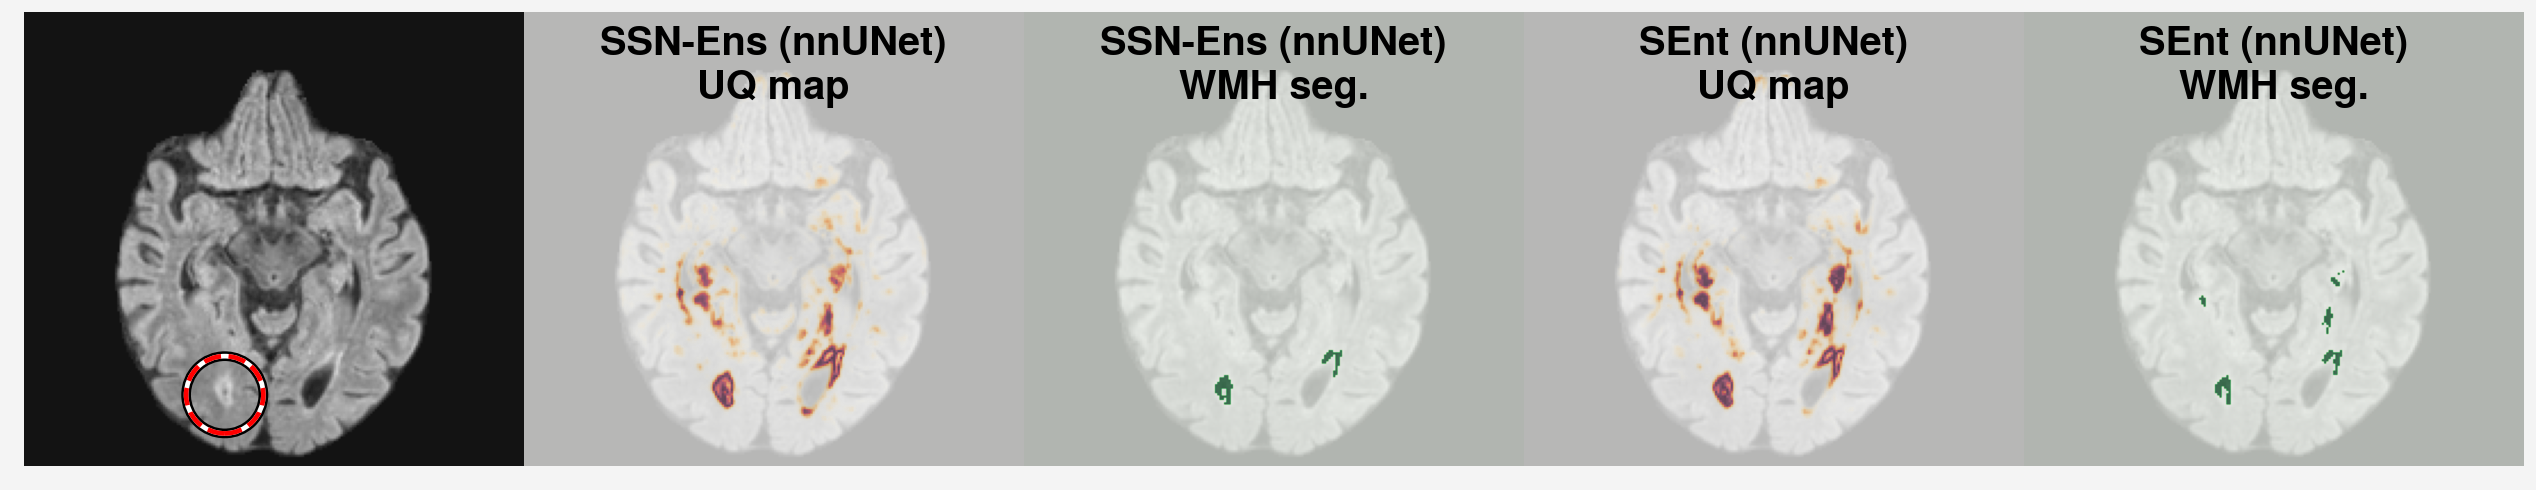

In [32]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_020_V1',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=1, r1=20, r2=10, figtitles=True, circle_centre=(98, 51), circle_radius=17)

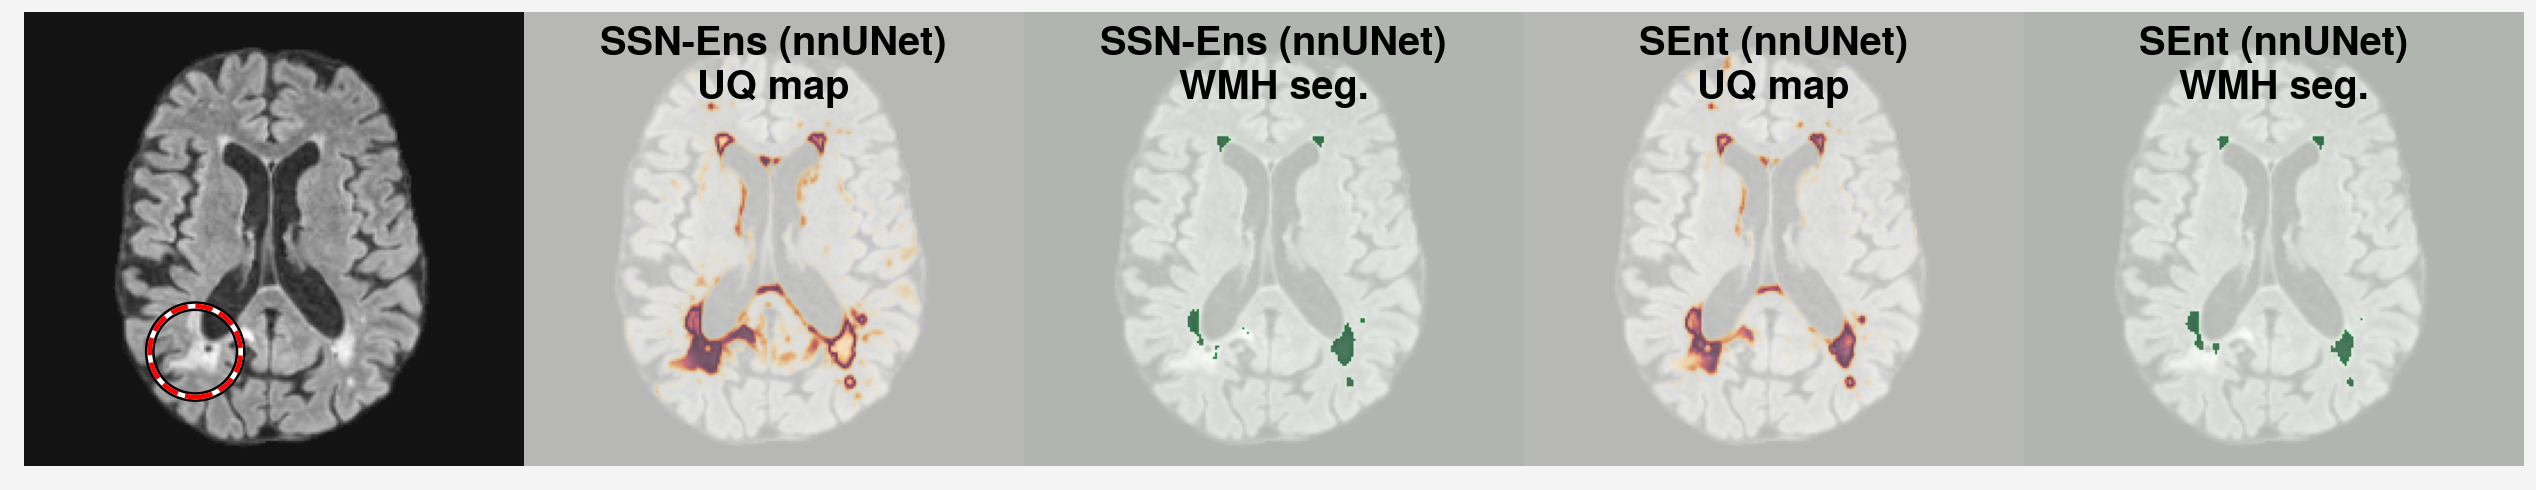

In [33]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_020_V1',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=2, r1=20, r2=10, figtitles=True, circle_centre=(85, 70), circle_radius=20)

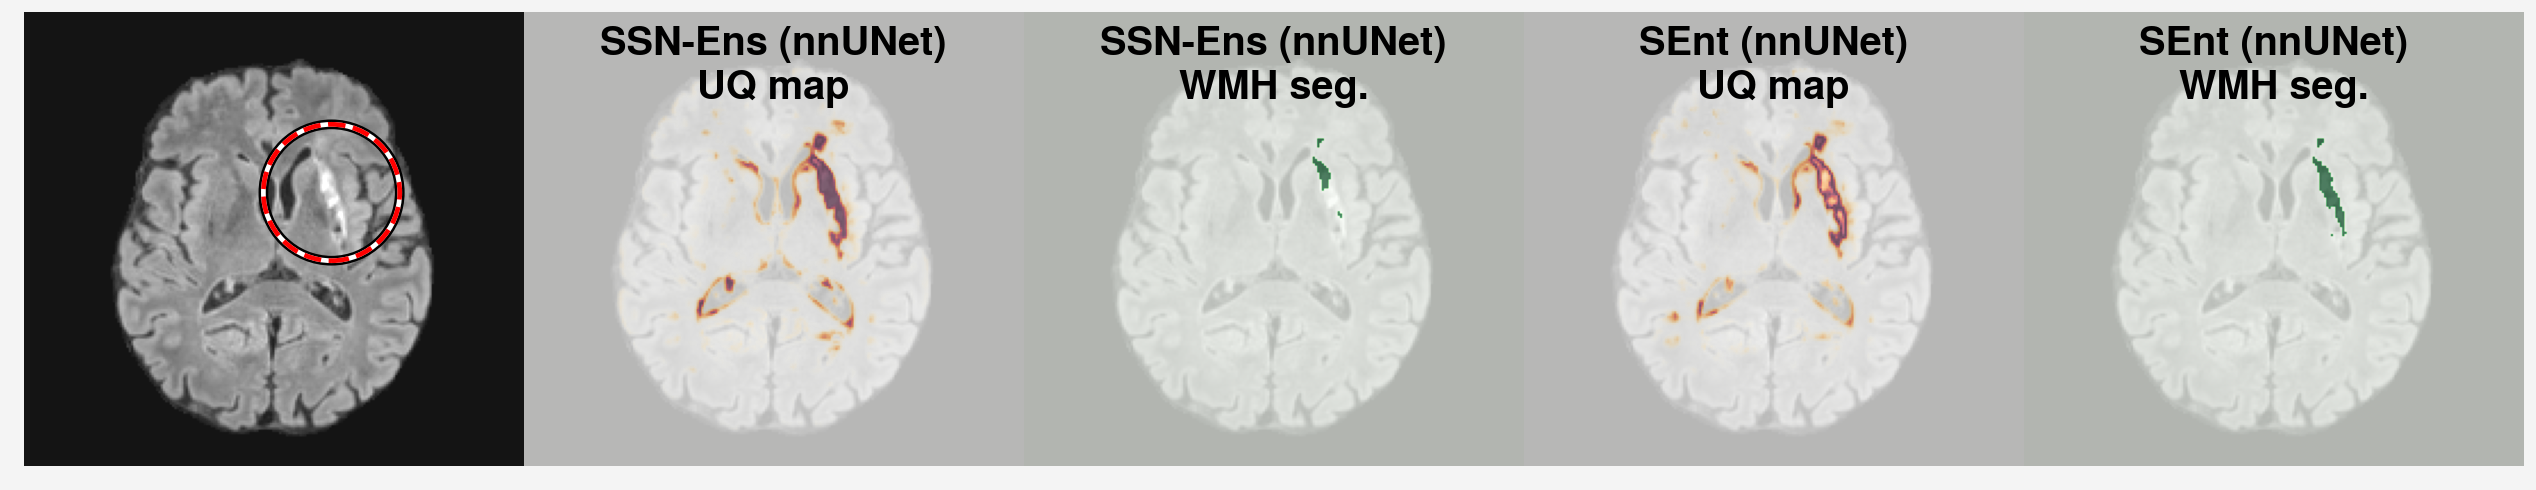

In [34]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_024_V1',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=2, r1=20, r2=10, figtitles=True, circle_centre=(145, 140), circle_radius=30)

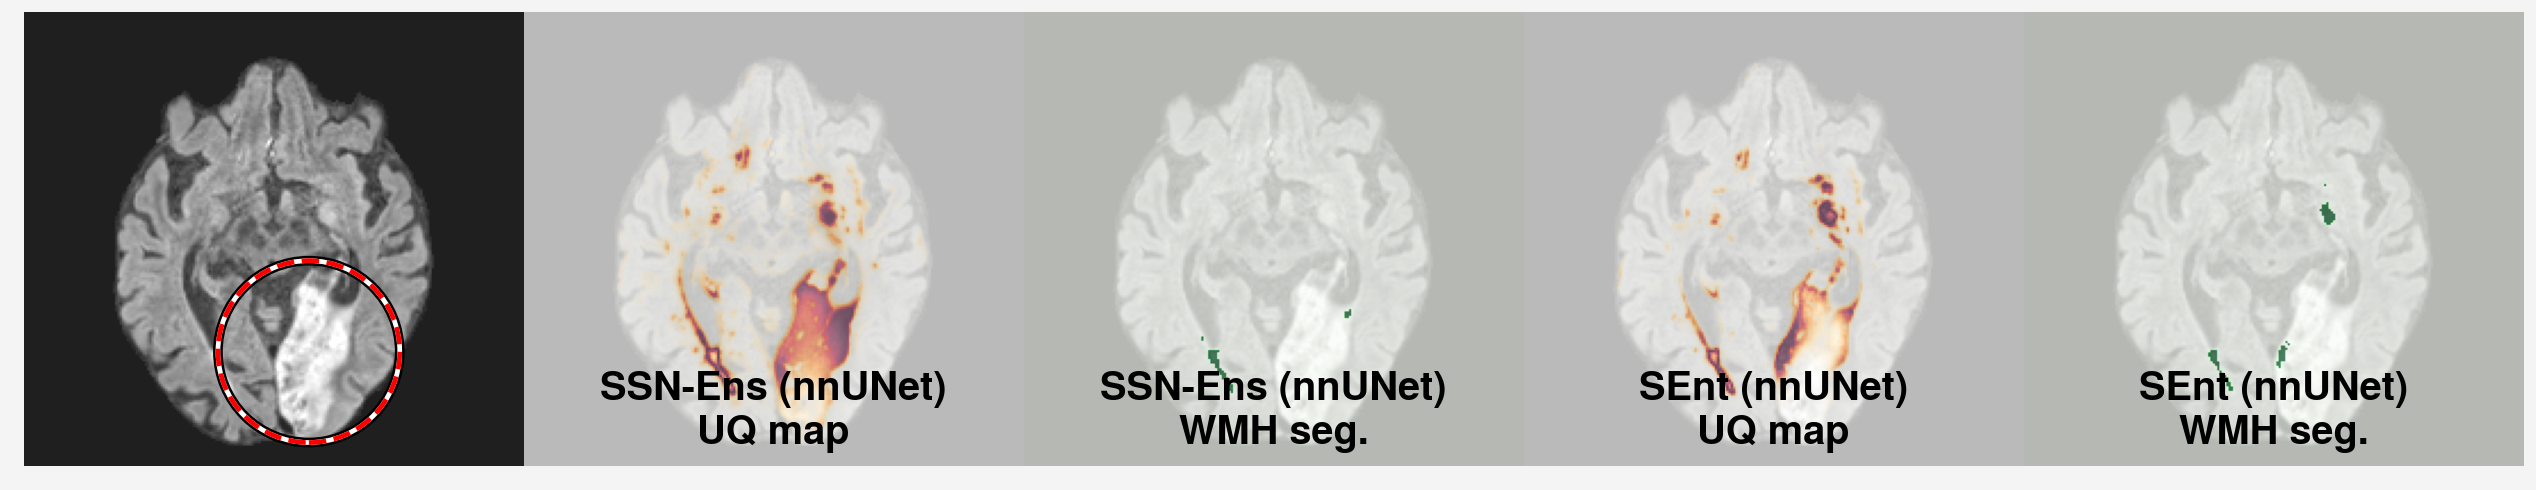

In [27]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_019_V1',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=1, r1=20, r2=10, figtitles=True, circle_centre=(135, 70), circle_radius=40)

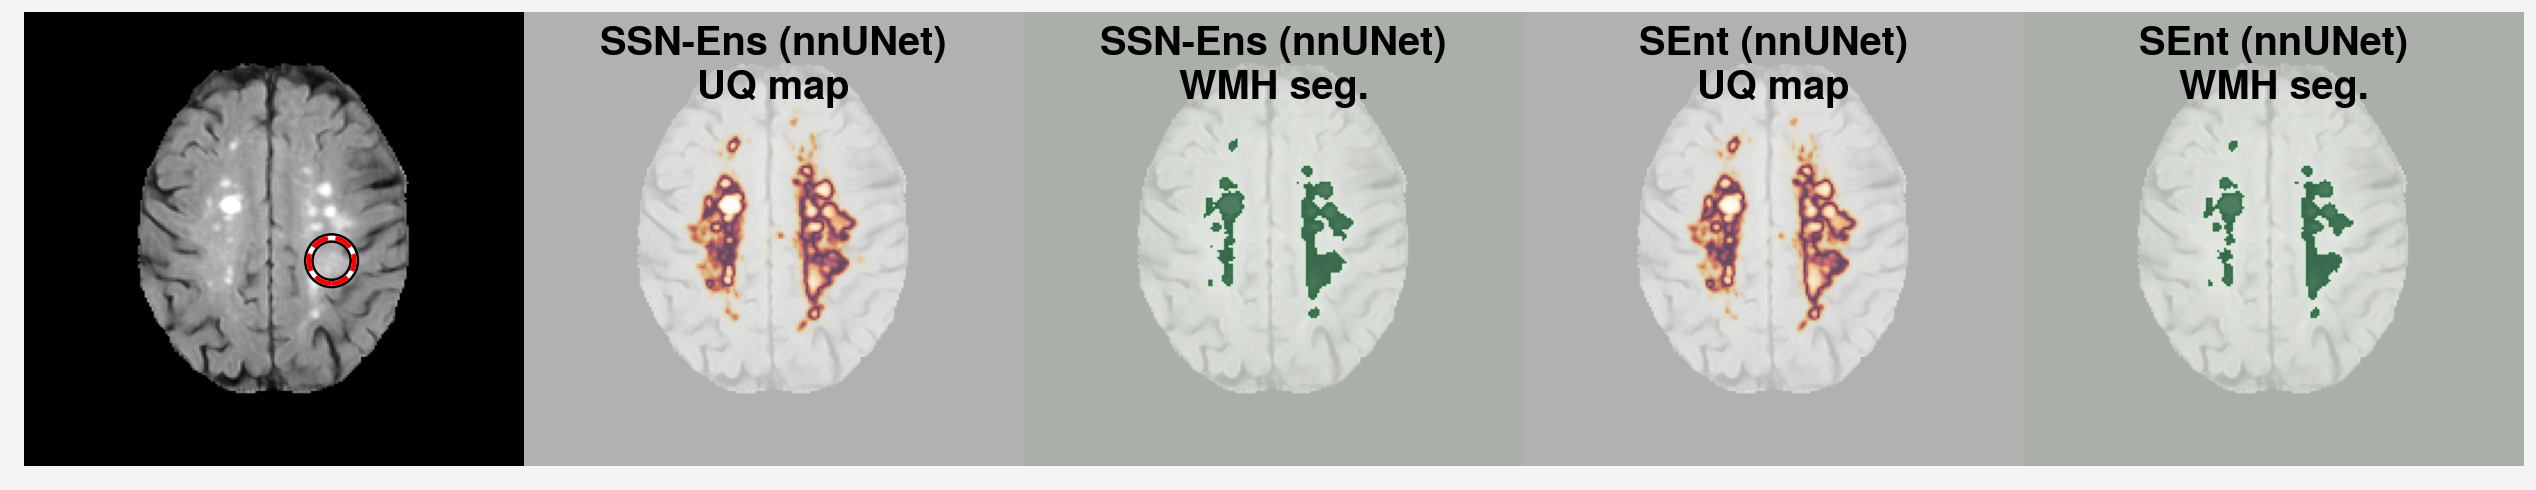

In [35]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_050_V0',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=3, r1=20, r2=10, figtitles=True, circle_centre=(145, 110), circle_radius=10)

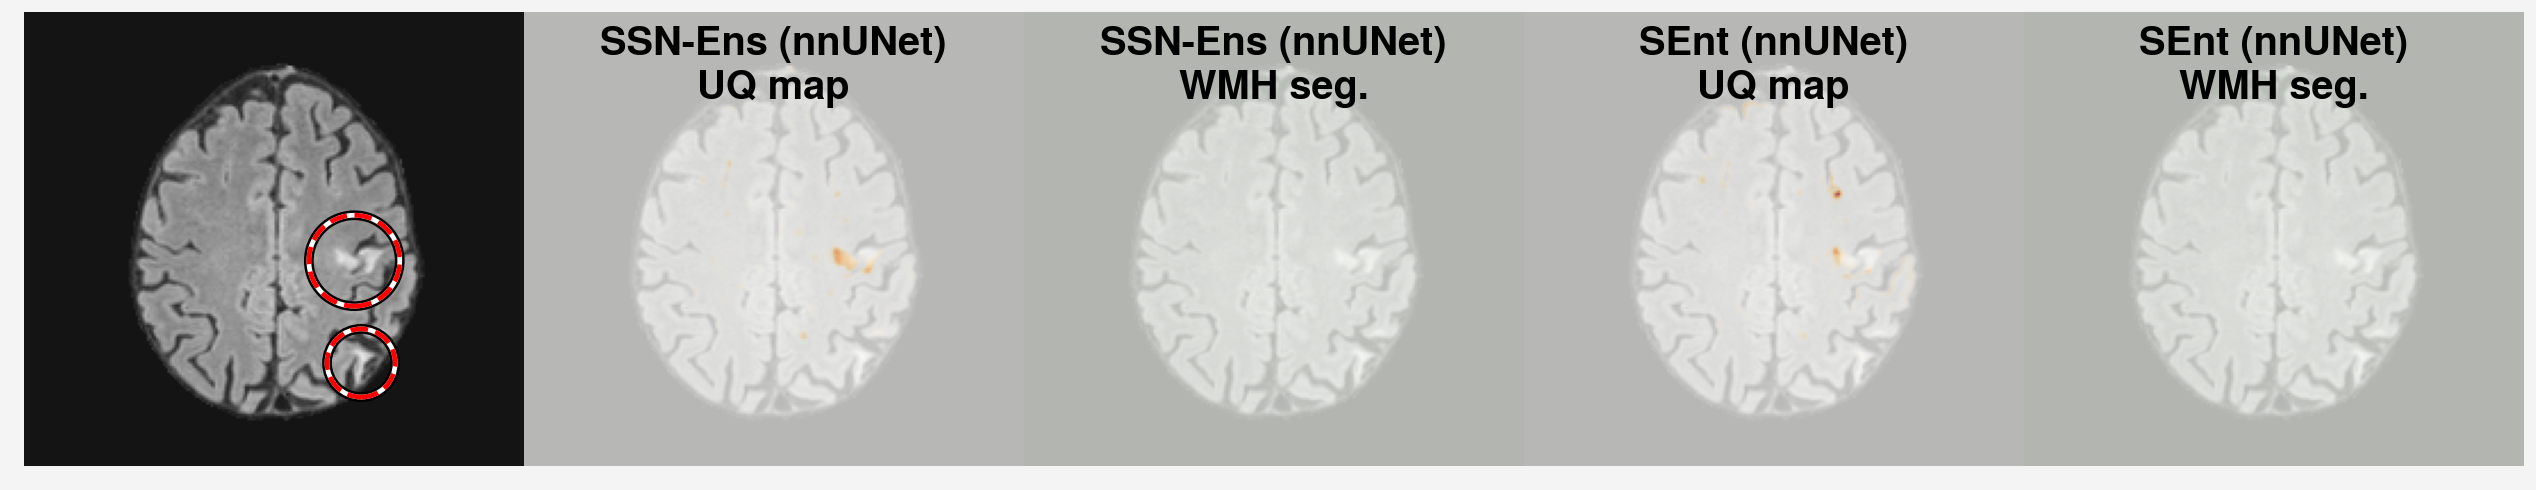

In [36]:
plot_brain_image_singlesice(mss3_ds, IDs, output_maps['nnunet/nnunetX2SsnEns2D'], output_maps['nnunet/nnunet2D'], 'ED_102_V4',
                            mss3_data['ssn_ens'], reverse_IDs_map, islice_index=3, r1=20, r2=10, figtitles=True, circle_centre=(155, 110), circle_radius=20,
                           second_circle_centre=(158, 65), second_circle_radius=15)

In [32]:
def plot_brain_image_punet_comparison(ds, IDs, output_maps_ssnens, output_maps_punet, target_pID, df, reverse_IDs_map, islice_index, r1=20, r2=10, figtitles=False, circle_centre=None, circle_radius=None, second_circle_centre=None, second_circle_radius=None, mark_locs=None):
    IDs = np.array(IDs)
    scan_id = np.where(IDs == reverse_IDs_map[target_pID])[0].item()
    
    nslices = ds[scan_id][0][0].shape[0]
    gap = nslices // 6
    islice = gap * (islice_index + 1) + 4

    fig = pplt.figure(space=0, refwidth='20em')
    axs = fig.subplots(nrows=1, ncols=2)
    axs.format(grid=False, xlocator='null', ylocator='null')
    for ax in axs:
        for spine in ax.spines:
            ax.spines[spine].set_color('none')

    flair = ds[scan_id][0][0]
    flair = flair.clone()
    mask = ds[scan_id][0][2]
    flair[mask==0] = flair.min()
            
    axs[0].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    if circle_centre is not None:
        circle = plt.Circle((circle_centre[0]-r2, circle_centre[1]-r1), radius=circle_radius, color='black', fill=False, linewidth=3.5)
        axs[0].add_patch(circle)
        circle = plt.Circle((circle_centre[0]-r2, circle_centre[1]-r1), radius=circle_radius, color='white', fill=False, linewidth=1.7)
        axs[0].add_patch(circle)
        circle = plt.Circle((circle_centre[0]-r2, circle_centre[1]-r1), radius=circle_radius, color='r', fill=False, linewidth=1.7, linestyle='--')
        axs[0].add_patch(circle)
        
    if second_circle_centre is not None:
        circle = plt.Circle((second_circle_centre[0]-r2, second_circle_centre[1]-r1), radius=second_circle_radius, color='black', fill=False, linewidth=3.5)
        axs[0].add_patch(circle)
        circle = plt.Circle((second_circle_centre[0]-r2, second_circle_centre[1]-r1), radius=second_circle_radius, color='white', fill=False, linewidth=1.7)
        axs[0].add_patch(circle)
        circle = plt.Circle((second_circle_centre[0]-r2, second_circle_centre[1]-r1), radius=second_circle_radius, color='r', fill=False, linewidth=1.7, linestyle='--')
        axs[0].add_patch(circle)
        
    if mark_locs is not None:
        for mark in mark_locs:
            axs[0].scatter(mark[0], mark[1], marker=mark[2], s=100, c='white')
            # axs[0].scatter(mark[0], mark[1], marker=mark[2], s=50, c='grape7')

    # flair + umap ssn ens
    axs[0].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[0].imshow(output_maps_ssnens[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    # flair + umap punet
    axs[1].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[1].imshow(output_maps_punet[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    
    if figtitles:
        # axs[0].set_title("FLAIR", fontweight='bold')
        axs[0].set_title("SSN-Ens UQ map", fontweight='bold')
        axs[1].set_title("P-Unet UQ map", fontweight='bold')
        axs.format(titleloc='lc', titleborder=False, fontsize=13)

    plt.savefig(f"images/mss3_punet_compare_{target_pID}_{islice_index}.png", dpi=200)
    plt.show()